# Overview

All scenario's notebooks have the same structure:

- [Description of the scenario](#description)
- [Analysis of the calibration step in the real world and obtain calibration values for SimGrid's execution](#calibration)
- [Analysis of the execution of the scenario and comparison with the predicted results obtained in SimGrid](#comparison)

<a id='description'></a>
# 1st scenario results

This file describes the steps used to perform the experiment, and provides visualizations of the results.

## Scenario

The scenario consists in 1 computing node. The datasource will send requests to it with various work amounts (loop iterations), the computing node once finishing the request sends the result to the Sink node, which does nothing but some logging.

The experiment lasts for 5 minutes and is repeated 4 times for each work amount (40*4=160 launches) to limit random effects.


Here are the parameters used:

```
----------------------------------------------------
PARAMETERS:
suffix: reprodscen1
Parallelization degree: 10
HostLogPath: /home/clem/logs_expe/goLogs/reprod_scenario1_/
nbIters: start=1, end=80000001, iter=2000000
Samples: 4
Timestamp file: /go/src/app/timestamps/default5TimeStamps.csv
First core used: 0
----------------------------------------------------

```

## Reproduce

This scenario was launched on Grid'5000's paravance cluster.

Example of node reservation: `oarsub -p "cluster='paravance'" -l host=4,walltime=6 -I`

The experiment was launched using: `repoPath="/home/ccourageuxsudan/SGMicroservices/calvin-microbenchmarks/rabbitmqGo/" onG5K=1 run=1 scenario=1 bash launcherReproduce.s`

## Output

Output logs for this scenario can be found under:

- For the calibration step: `results_reprod/reprod_calib_2021-04-08_10-02-48/`
- For the execution: `results_reprod/reprod_scenario1_2021-04-08_10-02-48/`

# Initialization code

In [3]:
library(viridis)
library(ggplot2)
library(plotly)
library(plyr)
library(dplyr)
library(tidyr)
library(tikzDevice)
library(gridExtra)
library(zoo)
library(ggpointdensity)
library(hexbin)

getwd()
# modify default plots size
options(repr.plot.width=15, repr.plot.height=7)
#setwd("yourpathifnecessary")

[1] "/home/clem/Code/github.com/klementc/calvin-microbenchmarks/comparison"

# Load Datasets

In [15]:
##### CALIBRATION
data_calibration <- as_tibble(read.csv("results_reprod/reprod_calib_2021-04-08_10-02-48/1_aggrResults_1-10000000-100000002_4.csv"))
summary(data_calibration)

# preprocess to obtain timestamps as seconds instead of microseconds
data_calibration$timestampSec <- as.numeric(as.character(data_calibration$timestamp)) / 1e9
data_calibration$computeDurSec <- as.numeric(as.character(data_calibration$computeDur)) / 1e9

data_calibration_sg <- as_tibble(read.csv("results_reprod/sg_calib/aggResults_1.csv"))
summary(data_calibration_sg)

###### LOAD EXECUTION
data_SG_load <- as_tibble(read.csv("results_reprod/sg_run/sg_load_scenario1.csv"))
data_load_RW <- as_tibble(read.csv("results_reprod/reprod_scenario1_2021-04-08_10-02-48/1_aggrResults_1-2000000-80000001_4.csv"))
data_load_RW$timestampSec <- as.numeric(as.character(data_load_RW$timestamp)) / 1e9
data_load_RW$computeDurSec <- as.numeric(as.character(data_load_RW$computeDur)) / 1e9



 serviceName            nbIter        timestamp          totDurInServ     
 Length:4400        Min.   :1e+00   Min.   :0.000e+00   Min.   :    1529  
 Class :character   1st Qu.:2e+07   1st Qu.:7.425e+10   1st Qu.: 7015653  
 Mode  :character   Median :5e+07   Median :1.485e+11   Median :16895020  
                    Mean   :5e+07   Mean   :1.485e+11   Mean   :17073497  
                    3rd Qu.:8e+07   3rd Qu.:2.228e+11   3rd Qu.:25966555  
                    Max.   :1e+08   Max.   :2.970e+11   Max.   :55130256  
   computeDur          parExec      totReqProcessed   scenario        
 Min.   :     247   Min.   :0.000   Min.   : 0.00   Length:4400       
 1st Qu.: 7012413   1st Qu.:0.000   1st Qu.:24.75   Class :character  
 Median :16892252   Median :1.000   Median :49.50   Mode  :character  
 Mean   :17071081   Mean   :0.538   Mean   :49.50                     
 3rd Qu.:25964756   3rd Qu.:1.000   3rd Qu.:74.25                     
 Max.   :55125467   Max.   :1.000   Max.   :99.00

       ts              qArr        instArr       startEx        endEx       
 Min.   :  4.00   Min.   :  4   Min.   :  4   Min.   :  4   Min.   :  4.00  
 1st Qu.: 76.03   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76.03  
 Median :151.02   Median :151   Median :151   Median :151   Median :151.02  
 Mean   :151.02   Mean   :151   Mean   :151   Mean   :151   Mean   :151.02  
 3rd Qu.:226.01   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226.01  
 Max.   :298.03   Max.   :298   Max.   :298   Max.   :298   Max.   :298.03  
     flops         
 Min.   :  270700  
 1st Qu.: 6938700  
 Median :16940700  
 Mean   :16940700  
 3rd Qu.:26942700  
 Max.   :33610700  

<a id='calibration'></a>
# Calibration Step

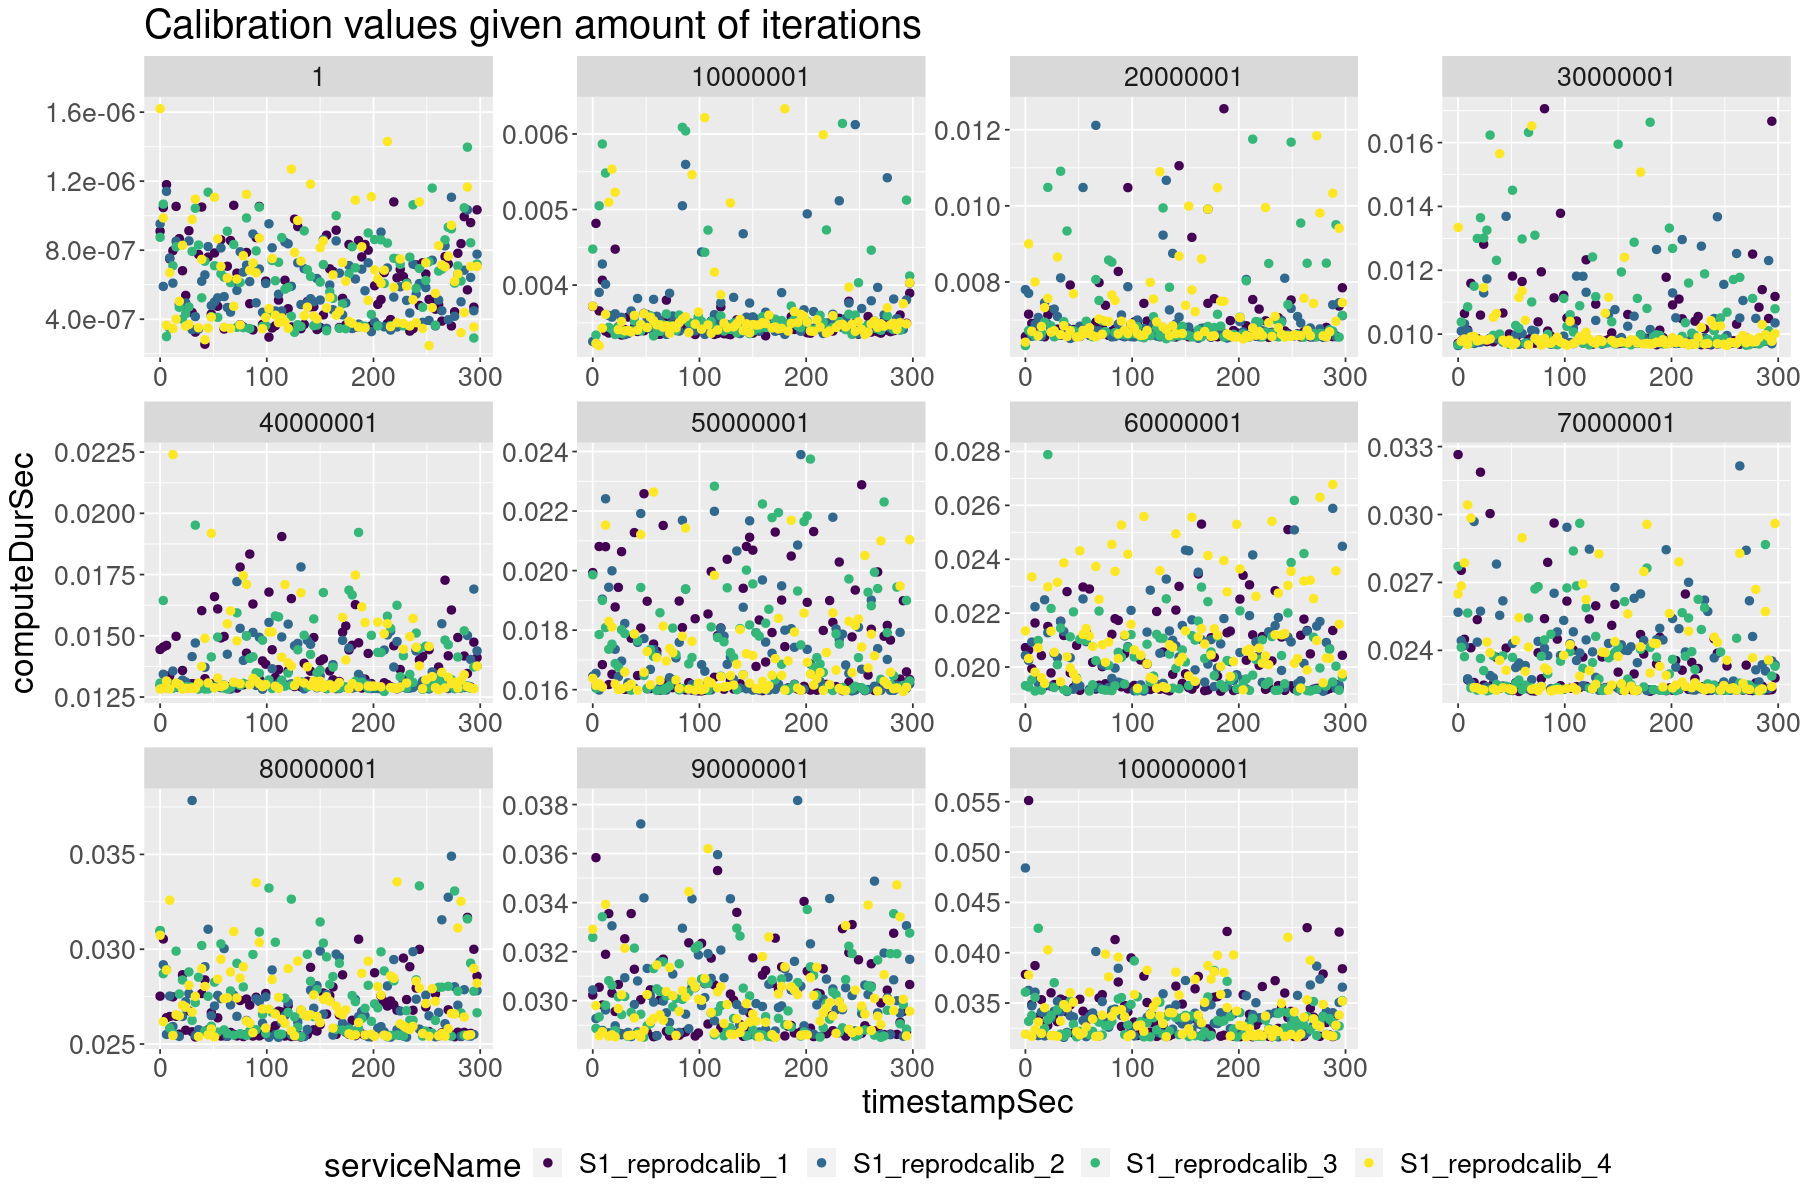

In [16]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data_calibration, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=2)+
    ggtitle("Calibration values given amount of iterations")+
    facet_wrap("nbIter", scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) 

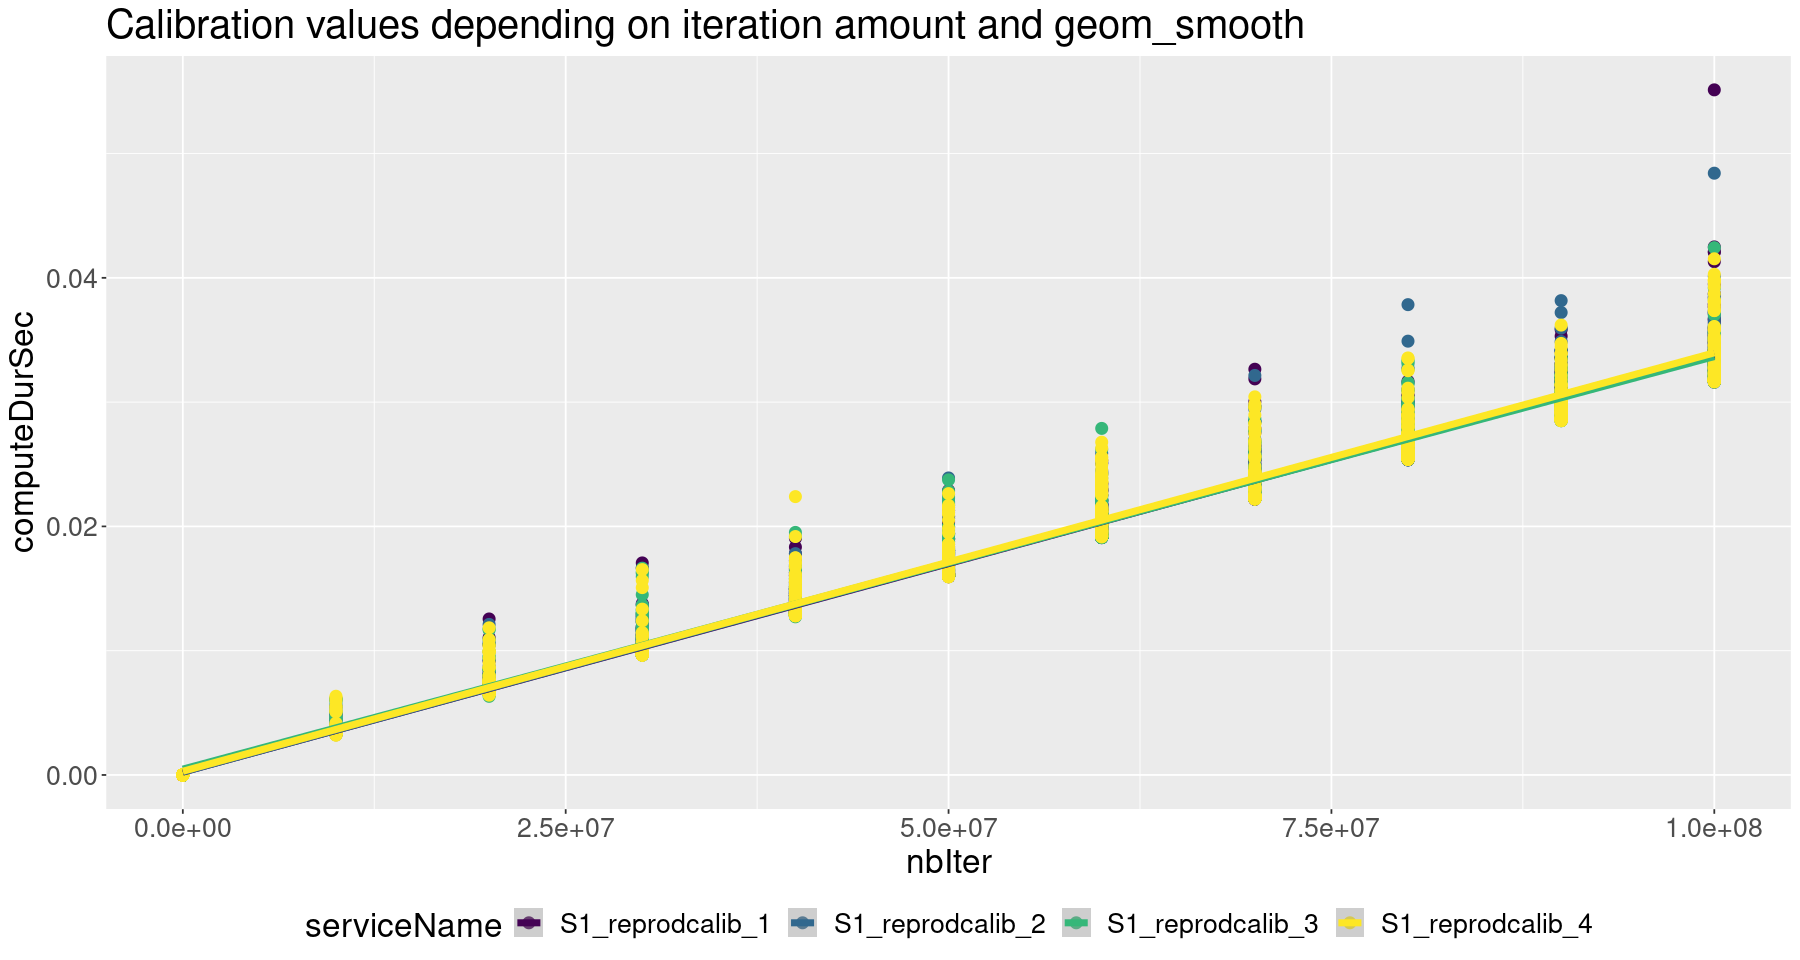

In [17]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data_calibration, aes(x=nbIter, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) + 
    ggtitle("Calibration values depending on iteration amount and geom_smooth")+
    geom_smooth(formula = y ~ x, method='lm', size=2)

## Linear regression to obtain calibration values

Given the previous graph, we can clearly observe (as expected) a linear relationship between the amount of work of the compute node, and the duration to execute a request. Thus we can use a linear regression to estimate the duration of a request given an amount of work (as a number of iterations). This value will then be used to calibrate our SimGrid code.

In [18]:
calibrationRegression = lm(computeDurSec ~ nbIter, data=data_calibration)
summary(calibrationRegression)


Call:
lm(formula = computeDurSec ~ nbIter, data = data_calibration)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0022420 -0.0008433 -0.0003091  0.0002970  0.0212929 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.096e-04  4.440e-05   6.973 3.56e-12 ***
nbIter      3.352e-10  7.505e-13 446.645  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001574 on 4398 degrees of freedom
Multiple R-squared:  0.9784,	Adjusted R-squared:  0.9784 
F-statistic: 1.995e+05 on 1 and 4398 DF,  p-value: < 2.2e-16


The obtained equation is:
### ```dur = nbIter*3.334*10**(-10)+2.707*10**(-4)``` 

## Utility function to obtain duration from nbIter

In [19]:
nbIter_to_duration <- function(nbIter) {
  return (nbIter*3.334*10**(-10)+2.707*10**(-4))
}

# utilitary function
nbIter_to_duration_to_SG <- function(start, end, iter, fact=1) {
    for(i in seq(from=start, to=end, by=iter)){
        cat(paste(trunc(fact*nbIter_to_duration(i)*10^9)," "))
    }
}

# example
print(nbIter_to_duration(2.5*10**8))
print(nbIter_to_duration(5*10**8))
print(nbIter_to_duration(7.5*10**8))

[1] 0.0836207
[1] 0.1669707
[1] 0.2503207


## Calibration comparison between real world data and SimGrid

In [20]:
start=1
end=100000002
iter=10000000

nbIter_to_duration_to_SG(start, end, iter)

270700  3604700  6938700  10272700  13606700  16940700  20274700  23608700  26942700  30276700  33610700  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > ~/logs_expe/sgLogs/calibration/aggrResults.csv
for i in 270700  3604700  6938700  10272700  13606700  16940700  20274700  23608700  26942700  30276700  33610700
do
    echo "Calibration for iterAmount=$i"
    scenario=1 parDeg=10 tsFile=../rabbitmqGo/timestamps/tsCal.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> ~/logs_expe/sgLogs/calibration/aggrResults.csv
done
```

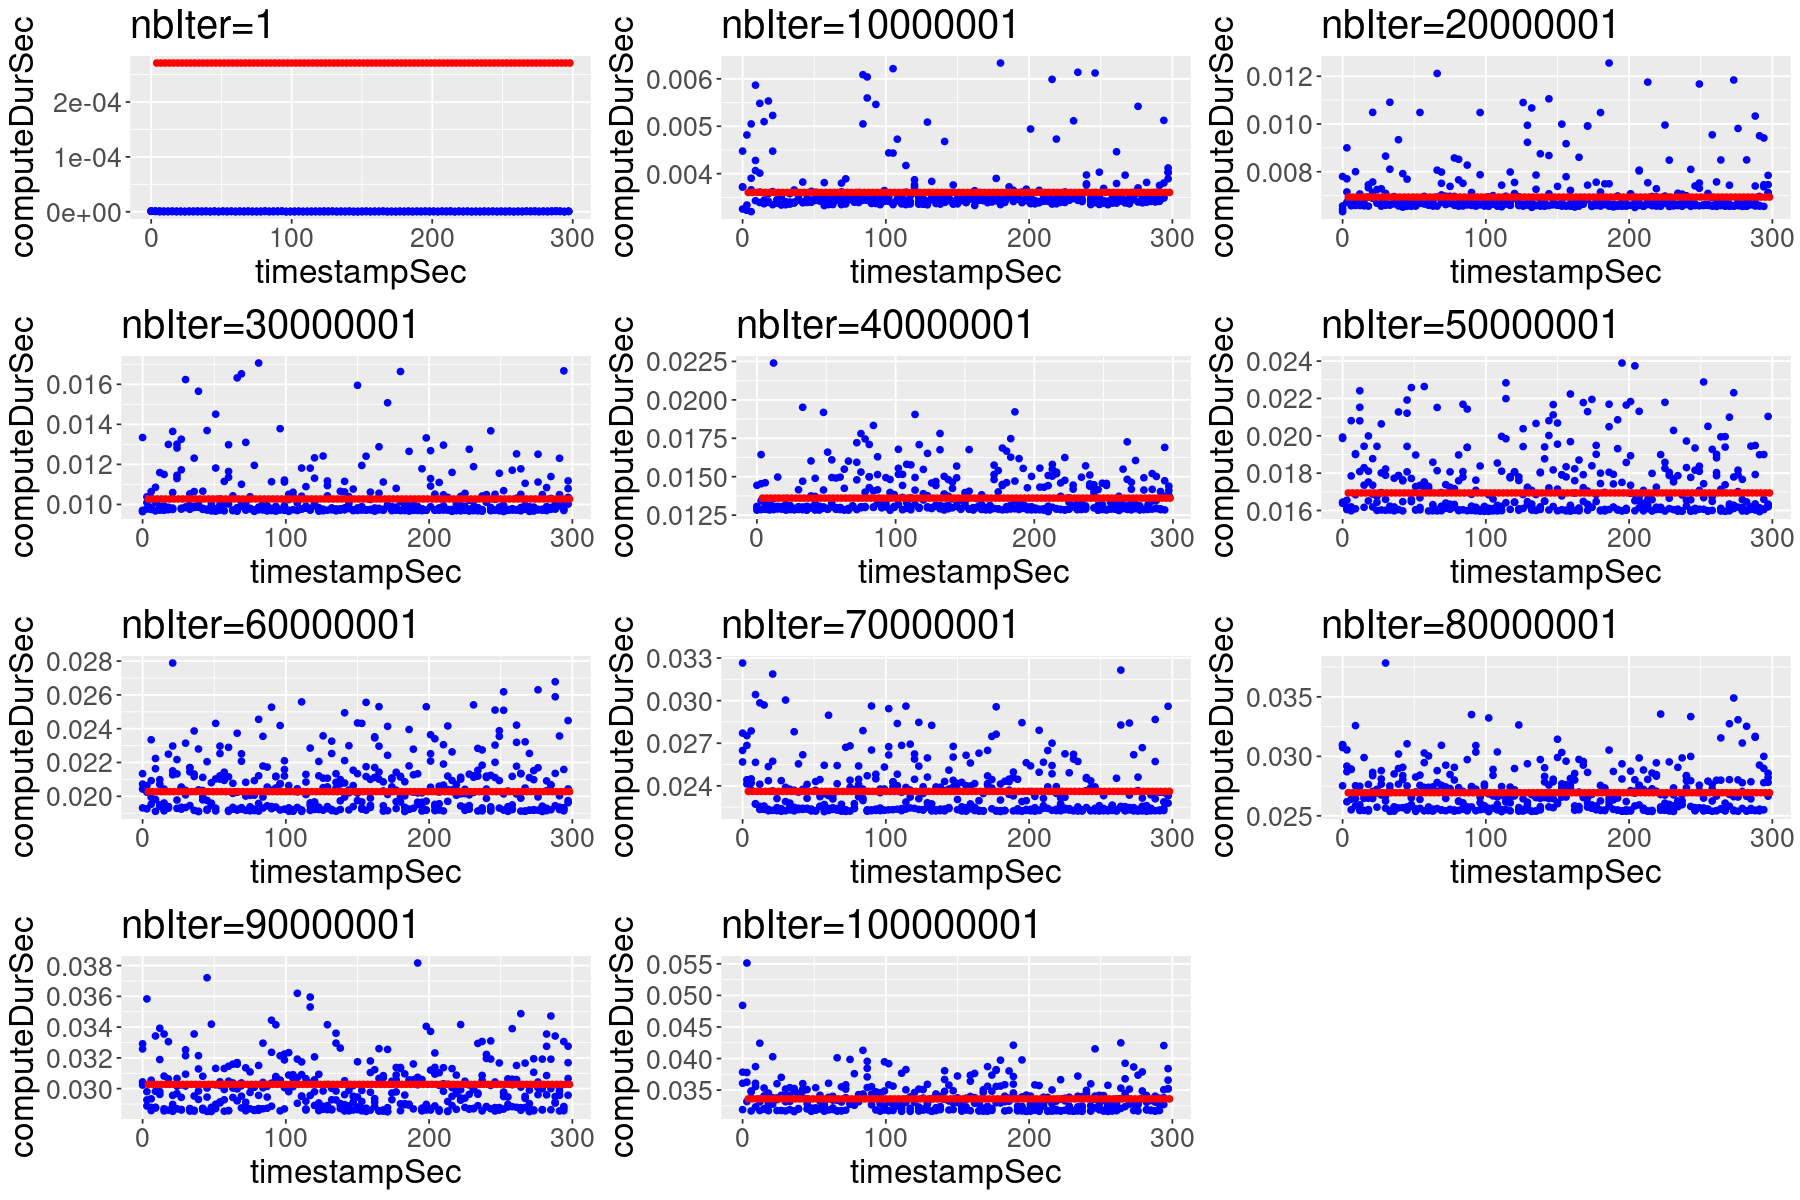

In [21]:
options(repr.plot.width=15, repr.plot.height=10)
P <- list()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red")+
        labs(title=sprintf("nbIter=%d",i))+
        theme(text = element_text(size = 20))+ 
        scale_color_viridis(discrete = TRUE, option = "D")+
        scale_fill_viridis(discrete = TRUE) 
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))

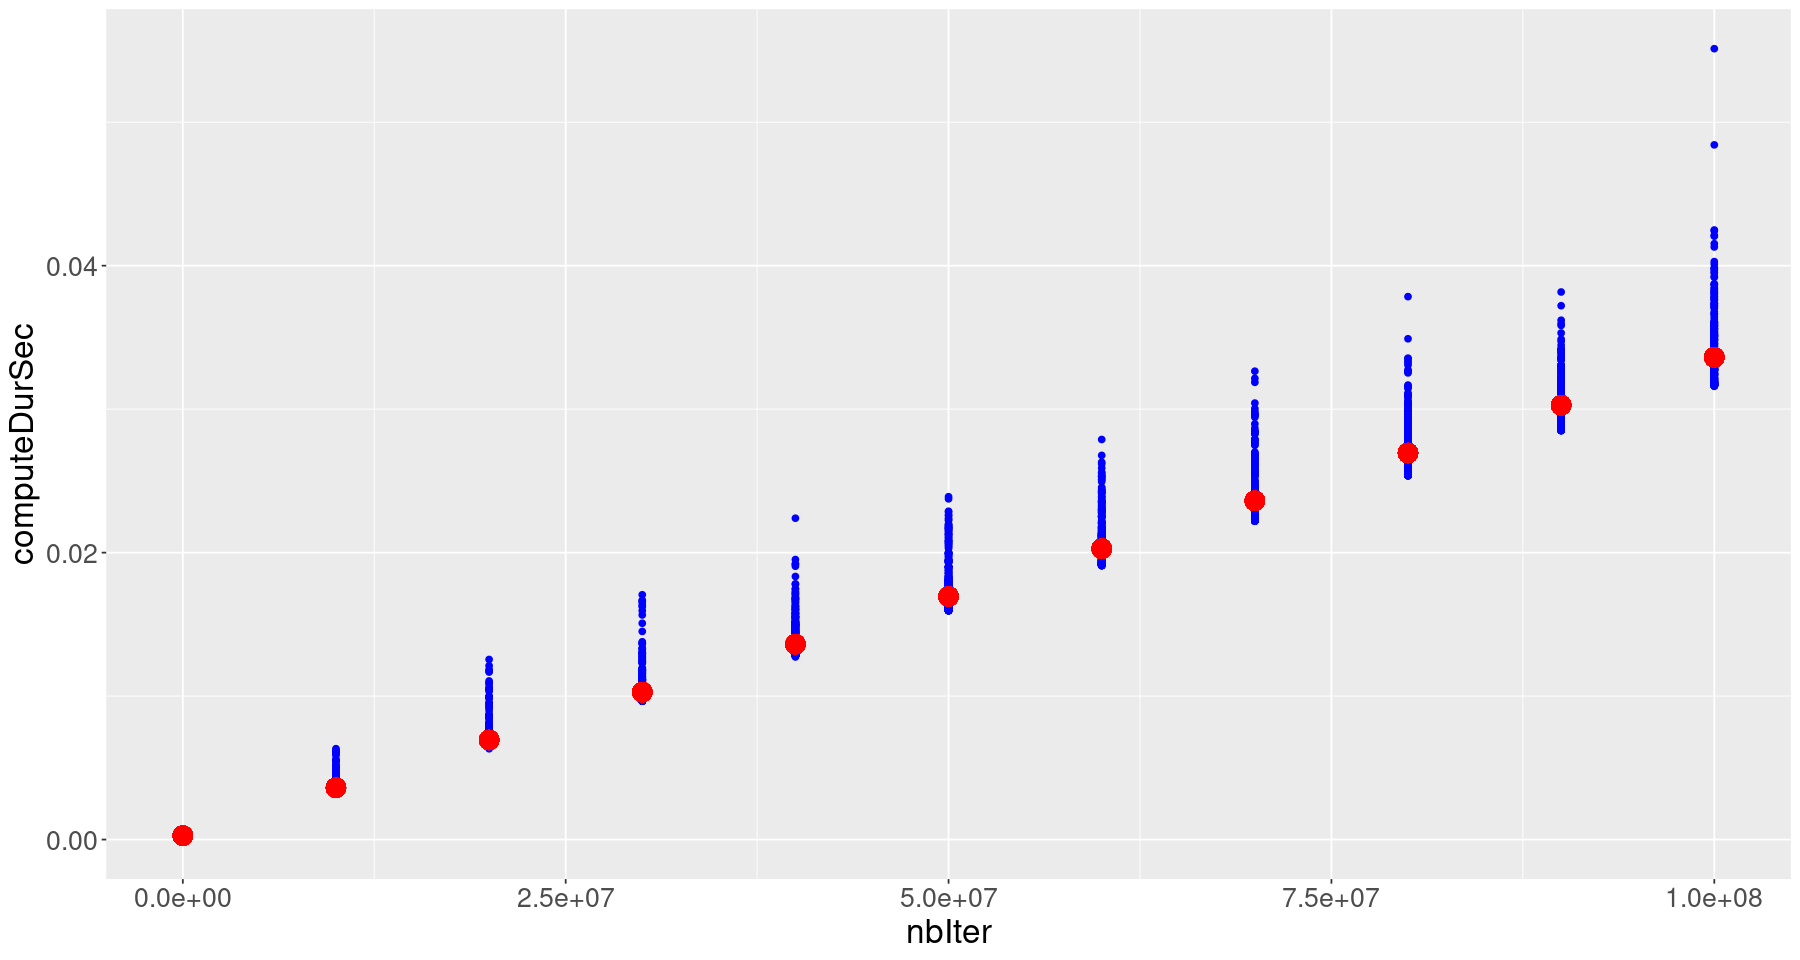

In [22]:

options(repr.plot.width=15, repr.plot.height=8)
P <- list()
g <- ggplot()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    tmpsg$nb <- i

    g <- g +
        geom_point(data = tmpG5K, aes(x=nbIter, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=nb, y=endEx-startEx), color = "red", size=5)+
        theme(text = element_text(size = 20))
    P <- c(P, list(g))
    
}
g

<a id='comparison'></a>
# Execution comparison


In [23]:
# obtain flop amount for 1GF nodes in SimGrid

start=1
end=80000001
iter=2000000

nbIter_to_duration_to_SG(start, end, iter)

270700  937500  1604300  2271100  2937900  3604700  4271500  4938300  5605100  6271900  6938700  7605500  8272300  8939100  9605900  10272700  10939500  11606300  12273100  12939900  13606700  14273500  14940300  15607100  16273900  16940700  17607500  18274300  18941100  19607900  20274700  20941500  21608300  22275100  22941900  23608700  24275500  24942300  25609100  26275900  26942700  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_load_scenario1.csv
for i in 270700  937500  1604300  2271100  2937900  3604700  4271500  4938300  5605100  6271900  6938700  7605500  8272300  8939100  9605900  10272700  10939500  11606300  12273100  12939900  13606700  14273500  14940300  15607100  16273900  16940700  17607500  18274300  18941100  19607900  20274700  20941500  21608300  22275100  22941900  23608700  24275500  24942300  25609100  26275900  26942700
do
    echo "Calibration for iterAmount=$i"
    scenario=1 parDeg=10 tsFile=default5TimeStamps.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_load_scenario1.csv
done
```

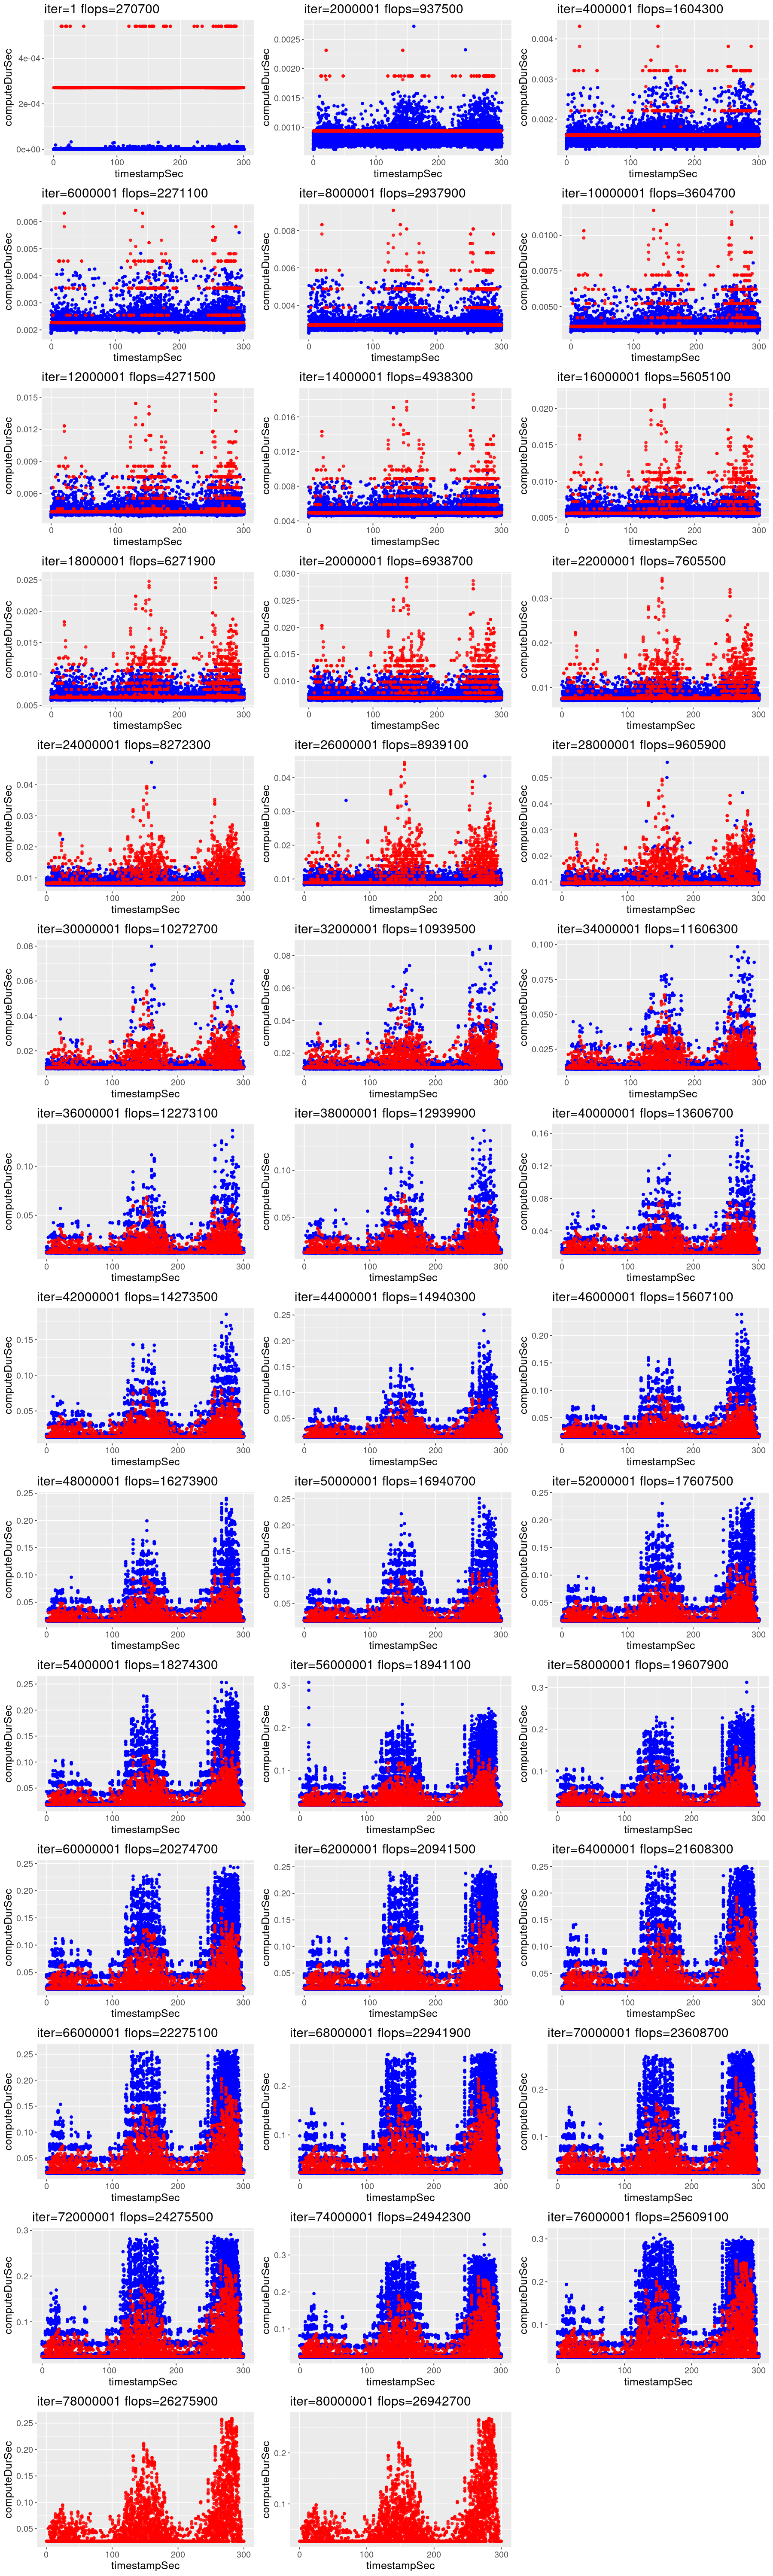

In [26]:

options(repr.plot.width=15, repr.plot.height=50)

P <- list()
for(i in seq(from=1, to=80000001, by=2000000)){
    tmpsg <- subset(data_SG_load, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red",alpha = 0.8)+
        labs(title=sprintf("iter=%d flops=%d",i,median(tmpsg$flops)))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))


# TEST compare average computation time over 1 second